In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Sep  8 00:01:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
pwd

'/content'

In [4]:
cd drive/MyDrive/metis/class_projects/waste_classification/data

/content/drive/MyDrive/metis/class_projects/waste_classification/data


In [5]:
#!unzip COMPLETE_DATASET.zip 

In [6]:
# import libraries
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from os import path
from glob import glob
from tqdm import tqdm

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tensorflow import keras 

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import Flatten, Dense, Dropout

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [43]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)

def model_performance_plot(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'Validation Accuracy')
    plt.legend()
    plt.savefig('../images/model_accuracy.png')
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.title('Training and Validation Binary Crossentropy Loss')
    plt.plot(hist['epoch'], hist['loss'],label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('../images/model_loss.png')
    plt.show()

In [8]:
# create directory paths for images (from dataset)
base_dir = './COMPLETE_DATASET'
train_dir = path.join(base_dir, 'TRAIN')
test_dir = path.join(base_dir, 'TEST')
print(train_dir)
print(test_dir)

./COMPLETE_DATASET/TRAIN
./COMPLETE_DATASET/TEST


# EDA

In [9]:
# .jpg files of organic images from train data
train_org = glob(path.join(train_dir, 'O', '*.jpg'))
print('Number of organic (train) images: ', len(train_org))

Number of organic (train) images:  12565


In [10]:
# .jpg files of recyclable images from train data
train_re = glob(path.join(train_dir, 'R', '*.jpg'))
print('Number of recyclable (train) images: ', len(train_re))

Number of recyclable (train) images:  9999


In [11]:
# .jpg files of organic images from train data
test_org = glob(path.join(test_dir, 'O', '*.jpg'))
print('Number of organic (test) images: ', len(test_org))

Number of organic (test) images:  1401


In [12]:
# .jpg files of organic images from train data
test_re = glob(path.join(test_dir, 'R', '*.jpg'))
print('Number of recyclable (test) images: ', len(test_re))

Number of recyclable (test) images:  1112


In [13]:
print('Number of total (train + test) images: ', len(train_org)+len(train_re)+len(test_org)+len(test_re))
print('Number of train (organic + recyclable) images: ', len(train_org)+len(train_re))
print('Number of test (organic + recyclable) images: ', len(test_org)+len(test_re))

Number of total (train + test) images:  25077
Number of train (organic + recyclable) images:  22564
Number of test (organic + recyclable) images:  2513


# IMAGE PREPROCESSING

In [14]:
img_height = 256
img_width = 256
batch_size = 32

In [15]:
# image scaling
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [16]:
# initialize train, testing generator
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [17]:
train_generator.class_indices

{'O': 0, 'R': 1}

In [18]:
# iterate batches -> store the data in x_train, y_train
train_generator.reset()
x_train, y_train = next(train_generator)

#1st batch is already fetched before the for loop
for i in tqdm(range(int(len(train_generator)/32)-1)): 
    img, label = next(train_generator)
    x_train = np.append(x_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(x_train.shape, y_train.shape)

100%|██████████| 21/21 [00:05<00:00,  3.68it/s]

(704, 256, 256, 3) (704,)


In [19]:
# iterate batches -> store the data in x_test, y_test
test_generator.reset()
x_test, y_test = next(test_generator)

#1st batch is already fetched before the for loop.
for i in tqdm(range(int(len(test_generator)/32)-1)): 
    img, label = next(test_generator)
    x_test = np.append(x_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)

print(x_test.shape, y_test.shape)

100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

(64, 256, 256, 3) (64,)


# NON DEEP LEARNING MODELS

In [20]:
print(x_train.ndim)
print(x_test.ndim)

4
4


In [21]:
# reshape x_train values; sklearn expects 2D array
nsamples, nx, ny, nrgb = x_train.shape
x_train_2d = x_train.reshape((nsamples,nx*ny*nrgb))

In [22]:
# reshape x_test values; sklearn expects 2D array
nsamples, nx, ny, nrgb = x_test.shape
x_test_2d = x_test.reshape((nsamples,nx*ny*nrgb))

## RANDOM FOREST CLASSIFIER

In [23]:
# reduce train data dimensions using PCA
pca = PCA(n_components=2)
pca.fit(x_train_2d)
x_train_2pc = pca.transform(x_train_2d)

# reduce test data dimensions using PCA
pca.fit(x_test_2d)
x_test_2pc = pca.transform(x_test_2d)

print(np.shape(x_train_2pc))
print(np.shape(x_test_2pc))

(704, 2)
(64, 2)


Text(0, 0.5, 'PCA Component 2')

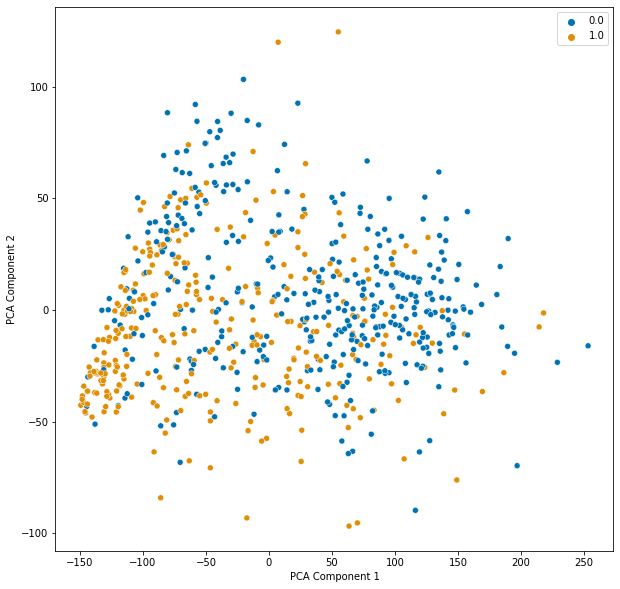

In [24]:
# plot PCA
plt.figure(figsize=(10,10))

sns.scatterplot(x=x_train_2pc[:, 0], y=x_train_2pc[:, 1],
                hue=y_train,
                palette=sns.color_palette("colorblind", 2))
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

In [25]:
# instantiate and fit random forest
rf = RandomForestClassifier()

rf.fit(x_train_2pc,y_train)

RandomForestClassifier()

In [26]:
# evaluate predicted values
rf_y_pred = rf.predict(x_test_2pc)
rf_y_pred[0:10]

array([0., 0., 0., 0., 0., 1., 0., 1., 0., 1.], dtype=float32)

In [27]:
# evaluate metrics
print(f"Random Forest MAE: {metrics.mean_absolute_error(y_test, rf_y_pred):,.4f}")
print(f"Random Forest MSE: {metrics.mean_squared_error(y_test, rf_y_pred):,.4f}")
print(f"Random Forest Accuracy: {metrics.accuracy_score(y_test, rf_y_pred):,.4f}")

Random Forest MAE: 0.3750
Random Forest MSE: 0.3750
Random Forest Accuracy: 0.6250


## LOGISTIC REGRESSION

In [28]:
# standardized values for logistic regression
sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train_2d)
x_test_scaled = sc.transform(x_test_2d)

In [29]:
# reduce train data dimensions using PCA
pca = PCA(n_components=2)
pca.fit(x_train_scaled)
x_train_scaled_2pc = pca.transform(x_train_scaled)

# reduce test data dimensions using PCA
pca.fit(x_test_scaled)
x_test_scaled_2pc = pca.transform(x_test_scaled)

print(np.shape(x_train_scaled_2pc))
print(np.shape(x_test_scaled_2pc))

(704, 2)
(64, 2)


In [30]:
# instantiate and fit logistic regression
lr = LogisticRegression()

lr.fit(x_train_scaled_2pc, y_train)

LogisticRegression()

In [31]:
# evaluate predicted values
lr_y_pred = lr.predict(x_test_scaled_2pc)
lr_y_pred[0:10]

array([0., 0., 1., 0., 0., 1., 0., 0., 1., 1.], dtype=float32)

In [32]:
# evaluate metrics
print(f"Logistic Regression MAE: {metrics.mean_absolute_error(y_test, rf_y_pred):,.4f}")
print(f"Logistic Regression MSE: {metrics.mean_squared_error(y_test, rf_y_pred):,.4f}")
print(f"Logistic Regression Accuracy: {metrics.accuracy_score(y_test, rf_y_pred):,.4f}")

Logistic Regression MAE: 0.3750
Logistic Regression MSE: 0.3750
Logistic Regression Accuracy: 0.6250


## ADDITIONAL PREPROCESSING

In [33]:
# image scaling
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0,
                                   validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [34]:
# initialize train, validation, testing generator
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42)

valid_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    seed=42)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [35]:
earlystopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0.005,
                              patience=4,
                              mode='max',
                              verbose=1)

checkpoint = ModelCheckpoint(filepath='./model_checkpoint/',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

callbacks = [earlystopping, checkpoint]

# SIMPLE NEURAL NET

In [36]:
model1 = Sequential()

model1.add(Flatten(input_shape=x_train.shape[1:]))
model1.add(Dense(units=20, activation='relu'))
model1.add(Dense(units=10, activation='relu'))
model1.add(Dense(units=1, activation='sigmoid'))

model1.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 20)                3932180   
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,932,401
Trainable params: 3,932,401
Non-trainable params: 0
_________________________________________________________________


In [37]:
simple_neural_net = model1.fit(train_generator,
                               epochs=20,
                               validation_data=valid_generator,
                               callbacks=callbacks)

Epoch 1/20
565/565 [==============================] - ETA: 0s - loss: 1.6757 - accuracy: 0.7123
Epoch 1: val_accuracy improved from -inf to 0.73027, saving model to ./model_checkpoint/
565/565 [==============================] - 83s 145ms/step - loss: 1.6757 - accuracy: 0.7123 - val_loss: 0.8306 - val_accuracy: 0.7303
Epoch 2/20
565/565 [==============================] - ETA: 0s - loss: 1.1785 - accuracy: 0.7217
Epoch 2: val_accuracy improved from 0.73027 to 0.77128, saving model to ./model_checkpoint/
565/565 [==============================] - 74s 131ms/step - loss: 1.1785 - accuracy: 0.7217 - val_loss: 0.8994 - val_accuracy: 0.7713
Epoch 3/20
565/565 [==============================] - ETA: 0s - loss: 0.6537 - accuracy: 0.7595
Epoch 3: val_accuracy improved from 0.77128 to 0.79942, saving model to ./model_checkpoint/
565/565 [==============================] - 74s 131ms/step - loss: 0.6537 - accuracy: 0.7595 - val_loss: 0.4791 - val_accuracy: 0.7994
Epoch 4/20
565/565 [=================

In [38]:
# evaluate model
neural_net_loss, neural_net_accuracy = model1.evaluate(test_generator)
print(f"Test Accuracy: {neural_net_accuracy:.4f}")
print(f"Test Loss: {neural_net_loss:.4f}")

79/79 [==============================] - 8s 103ms/step - loss: 0.3754 - accuracy: 0.8639
Test Accuracy: 0.8639
Test Loss: 0.3754


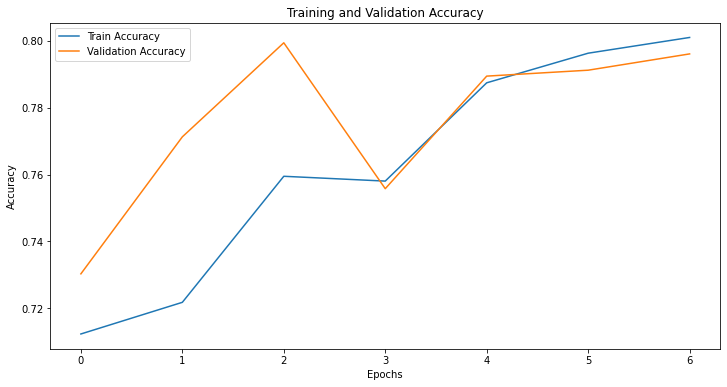

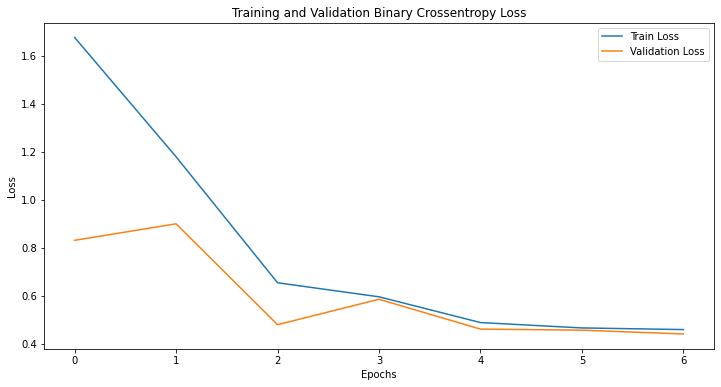

In [44]:
# plot model performance
model_performance_plot(simple_neural_net)

# SIMPLE CNN

In [40]:
model2 = Sequential()

model2.add(InputLayer(input_shape=(256,256,3)))

model2.add(Conv2D(filters=16,kernel_size=3,activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
    
model2.add(Flatten())
    
model2.add(Dense(16, activation='relu'))
    
model2.add(Dense(1, activation='sigmoid'))
    
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 258064)            0         
                                                                 
 dense_3 (Dense)             (None, 16)                4129040   
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,129,505
Trainable params: 4,129,505
Non-trainable params: 0
____________________________________________

In [41]:
simple_cnn = model2.fit(train_generator,
                        epochs=20,
                        validation_data=valid_generator,
                        callbacks=callbacks)

Epoch 1/20
565/565 [==============================] - ETA: 0s - loss: 0.5569 - accuracy: 0.7964
Epoch 1: val_accuracy did not improve from 0.79942
565/565 [==============================] - 77s 133ms/step - loss: 0.5569 - accuracy: 0.7964 - val_loss: 0.4545 - val_accuracy: 0.7943
Epoch 2/20
565/565 [==============================] - ETA: 0s - loss: 0.3392 - accuracy: 0.8638
Epoch 2: val_accuracy did not improve from 0.79942
565/565 [==============================] - 73s 129ms/step - loss: 0.3392 - accuracy: 0.8638 - val_loss: 0.4864 - val_accuracy: 0.7773
Epoch 3/20
565/565 [==============================] - ETA: 0s - loss: 0.2297 - accuracy: 0.9129
Epoch 3: val_accuracy did not improve from 0.79942
565/565 [==============================] - 73s 130ms/step - loss: 0.2297 - accuracy: 0.9129 - val_loss: 0.4804 - val_accuracy: 0.7897
Epoch 4/20
565/565 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.9449
Epoch 4: val_accuracy did not improve from 0.79942
565/565 [=

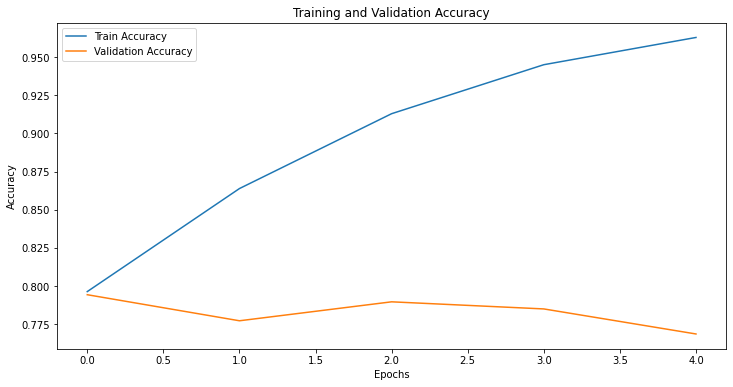

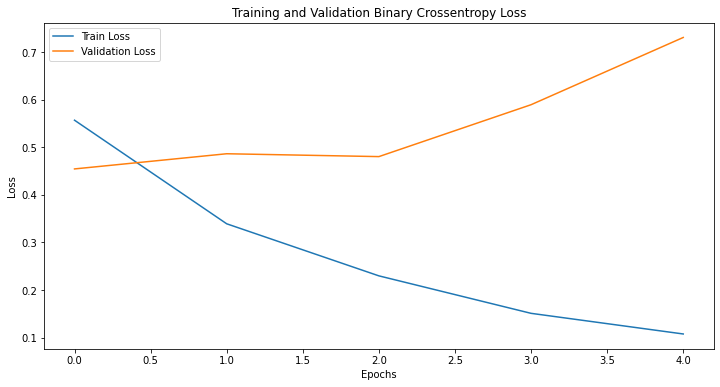

In [45]:
model_performance_plot(simple_cnn)

In [46]:
# evaluate model
simple_loss, simple_accuracy = model2.evaluate(test_generator)
print(f"Test Accuracy: {simple_accuracy:.4f}")
print(f"Test Loss: {simple_loss:.4f}")

79/79 [==============================] - 9s 112ms/step - loss: 0.5672 - accuracy: 0.8245
Test Accuracy: 0.8245
Test Loss: 0.5672


# COMPLEX CNN

In [47]:
model3 = Sequential()

model3.add(InputLayer(input_shape=(256,256,3)))

model3.add(Conv2D(filters=16, kernel_size=3, padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D())

model3.add(Conv2D(filters=32, kernel_size=3, padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D())

# model3.add(Conv2D(filters=64, kernel_size=3, padding='same'))
# model3.add(BatchNormalization())
# model3.add(Activation('relu'))
# model3.add(MaxPooling2D())

model3.add(Flatten())

# model3.add(Dense(64))
# model3.add(BatchNormalization())
# model3.add(Activation('relu'))
# model3.add(Dropout(0.5))

model3.add(Dense(32))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

model3.add(Dense(16))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

model3.add(Dense(1))
model3.add(BatchNormalization())
model3.add(Activation('sigmoid'))

model3.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)    

In [48]:
complex_cnn = model3.fit(train_generator,
                        epochs=20,
                        validation_data=valid_generator,
                        callbacks=callbacks)

Epoch 1/20
565/565 [==============================] - ETA: 0s - loss: 0.5222 - accuracy: 0.7645
Epoch 1: val_accuracy did not improve from 0.79942
565/565 [==============================] - 75s 130ms/step - loss: 0.5222 - accuracy: 0.7645 - val_loss: 0.4790 - val_accuracy: 0.7945
Epoch 2/20
565/565 [==============================] - ETA: 0s - loss: 0.4441 - accuracy: 0.8205
Epoch 2: val_accuracy did not improve from 0.79942
565/565 [==============================] - 75s 132ms/step - loss: 0.4441 - accuracy: 0.8205 - val_loss: 0.4441 - val_accuracy: 0.7945
Epoch 3/20
565/565 [==============================] - ETA: 0s - loss: 0.4062 - accuracy: 0.8375
Epoch 3: val_accuracy did not improve from 0.79942
565/565 [==============================] - 74s 131ms/step - loss: 0.4062 - accuracy: 0.8375 - val_loss: 0.5238 - val_accuracy: 0.7376
Epoch 4/20
565/565 [==============================] - ETA: 0s - loss: 0.3826 - accuracy: 0.8487
Epoch 4: val_accuracy did not improve from 0.79942
565/565 [=

In [49]:
# evaluate model
complex_loss, complex_accuracy = model3.evaluate(test_generator)
print(f"Test Accuracy: {complex_accuracy:.4f}")
print(f"Test Loss: {complex_loss:.4f}")

79/79 [==============================] - 9s 107ms/step - loss: 0.4081 - accuracy: 0.8261
Test Accuracy: 0.8261
Test Loss: 0.4081


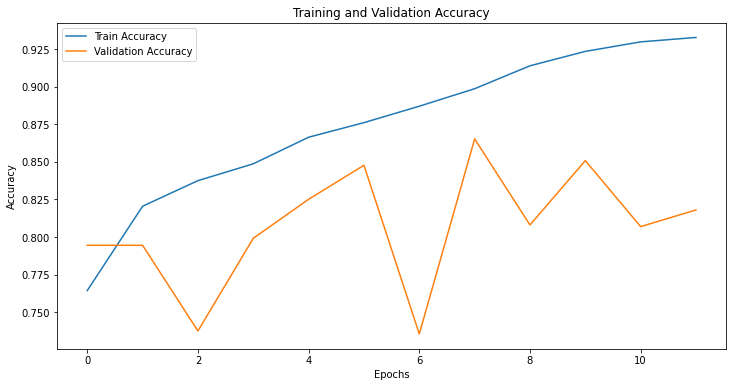

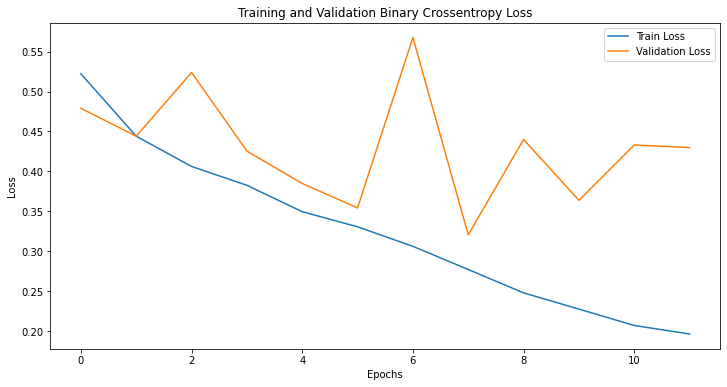

In [50]:
model_performance_plot(complex_cnn)

In [ ]:
Y_pred = model.predict_generator(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names)) 

In [ ]:
conf_mat = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(conf_mat, index = target_names, columns = target_names)
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

In [ ]:
class_mapping = {v:k for k,v in train_generator.class_indices.items()}


In [ ]:
def image_type(filename):
    
    if "glass" in filename:
        return 'glass'
    elif "metal" in filename:
        return 'metal'
    elif "paper" in filename:
        return 'paper'
    elif "plastic" in filename:
        return 'plastic'
    elif "cardboard" in filename:
        return 'cardboard'
    

def plot_predicted_label(nrows, ncols,onlyfiles):
    fig, axes = plt.subplots(nrows, ncols,figsize=(20, 13))
    
    rs = np.random.choice(len(onlyfiles),nrows*ncols,replace=False)
    
    for i, ax in zip(rs, axes.flat):
        img = cv2.imread(os.path.join(predict_dir, onlyfiles[i]))
        true_type = image_type(onlyfiles[i])
        img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1])) 
        img = img /255
         
        probabilities = model.predict(np.asarray([img]))[0]
        class_idx = np.argmax(probabilities)
            
        title = 'True: %s, Pred: %s , Confi:%0.2f' % (true_type,class_mapping[class_idx],probabilities[class_idx])
        ax.imshow(img, cmap='binary')
        ax.set_title(title)
         
        ax.set_xticks([])
        ax.set_yticks([])

        
num_rows = 2
num_cols = 4

# load image path to predict
onlyfiles = [f for f in listdir(predict_dir) if isfile(join(predict_dir, f))]

plot_predicted_label(num_rows, num_cols,onlyfiles);

In [ ]:
def predict_func(img): 
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img))
    if result == 0: print("\033[94m"+"This image -> Recyclable"+"\033[0m")
    elif result ==1: print("\033[94m"+"This image -> Organic"+"\033[0m")

In [ ]:
test_img = cv2.imread("/kaggle/input/waste-classification-data/DATASET/TEST/O/O_12573.jpg")
predict_func(test_img)

In [ ]:
test_img = cv2.imread("/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10753.jpg")
predict_func(test_img)

In [ ]:
# Test Case:1 - ORGANIC

dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('../input/waste-classification-data/DATASET/TEST/O/O_12650.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

In [ ]:
# Test Case:2 - RECYCLE

dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('../input/waste-classification-data/DATASET/TEST/R/R_10011.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")